In [32]:
import numpy as np
import open3d as o3d
import os
import time
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
def measure_execution_time(start_time):
    end_time = time.time()
    print(f"Total time taken: {end_time - start_time:.2f} seconds")

In [3]:
# Start timing
total_start_time = time.time()

# Read point cloud data
file_path = "../DATA/"
pcd_local = o3d.io.read_point_cloud(file_path+"hilton.ply")

measure_execution_time(total_start_time)

Total time taken: 2.81 seconds


In [4]:
# Start timing
total_start_time = time.time()

pcd_remote = o3d.io.read_point_cloud(file_path+"purple.ply")

measure_execution_time(total_start_time)

Total time taken: 2.64 seconds


In [5]:
# Print number of points
print(f"Number of points in pcd_local: {len(np.asarray(pcd_local.points))}")
print(f"Number of points in pcd_remote: {len(np.asarray(pcd_remote.points))}")

Number of points in pcd_local: 2501248
Number of points in pcd_remote: 2371625


In [6]:
# Start timing
total_start_time = time.time()

# Get bounding box for each point cloud
bbox_local = pcd_local.get_axis_aligned_bounding_box()
bbox_remote = pcd_remote.get_axis_aligned_bounding_box()

# Get the left down point (min bound) of the bounding box for each point cloud
anchor_local = bbox_local.get_min_bound()
anchor_remote = bbox_remote.get_min_bound()

# Initialize 3D affine transformation for each point cloud with identity matrices
mat_local = np.eye(4)
mat_remote = np.eye(4)

# Set the translation part of the affine matrix to the negative of the anchor point
mat_local[:3, 3] = -anchor_local
mat_remote[:3, 3] = -anchor_remote

# Apply the transformations to the point clouds
pcd_local.transform(mat_local)
pcd_remote.transform(mat_remote)

# Get bounding box for each point cloud again
bbox_local = pcd_local.get_axis_aligned_bounding_box()
bbox_remote = pcd_remote.get_axis_aligned_bounding_box()
# Set the color of the bounding boxes to blue
bbox_local.color = [0, 0, 1]
bbox_remote.color = [0, 0, 1]

measure_execution_time(total_start_time)

Total time taken: 0.11 seconds


In [7]:
# Start timing
total_start_time = time.time()

# Segmentation(to remove ceiling)
pt_to_plane_dist = 0.03
plane_model_loc, inliers_loc = pcd_local.segment_plane(distance_threshold=pt_to_plane_dist, ransac_n=3, num_iterations=1000)
plane_model_rmt, inliers_rmt = pcd_remote.segment_plane(distance_threshold=pt_to_plane_dist, ransac_n=3, num_iterations=1000)
outlier_loc = pcd_local.select_by_index(inliers_loc, invert=True)
outlier_rmt = pcd_remote.select_by_index(inliers_rmt, invert=True)
# remove ceiling
pcd_local = outlier_loc
pcd_remote = outlier_rmt

measure_execution_time(total_start_time)

Total time taken: 3.71 seconds


In [8]:
# Start timing
total_start_time = time.time()

# Define the spatial hashing parameters
grid_size = 0.2  # Size of each voxel cell

# Convert point clouds to numpy arrays
points_local = np.asarray(pcd_local.points)
points_remote = np.asarray(pcd_remote.points)

# Spatial hash map to store cells occupied by points in each point cloud
hash_map_local = defaultdict(list)
hash_map_remote = defaultdict(list)

# Hash function to map a 3D coordinate to a cell key
def hash_point(point, grid_size):
    # Calculate cell coordinates for the point
    cell_coords = tuple((point // grid_size).astype(int))
    return cell_coords
    
measure_execution_time(total_start_time)

Total time taken: 0.00 seconds


In [9]:
# Start timing
total_start_time = time.time()

# Insert points into the hash map for pcd_local
for point in points_local:
    cell_key = hash_point(point, grid_size)
    hash_map_local[cell_key].append(point)
    
measure_execution_time(total_start_time)

Total time taken: 5.99 seconds


In [10]:
# Start timing
total_start_time = time.time()

# Insert points into the hash map for pcd_remote
for point in points_remote:
    cell_key = hash_point(point, grid_size)
    hash_map_remote[cell_key].append(point)

measure_execution_time(total_start_time)

Total time taken: 5.76 seconds


In [11]:
# Function to create a line set representing a cube (voxel)
def create_voxel_wireframe(center, size):
    # Define the 8 corners of the voxel
    half_size = size / 2.0
    corners = [
        center + np.array([half_size, half_size, half_size]),
        center + np.array([half_size, half_size, -half_size]),
        center + np.array([half_size, -half_size, half_size]),
        center + np.array([half_size, -half_size, -half_size]),
        center + np.array([-half_size, half_size, half_size]),
        center + np.array([-half_size, half_size, -half_size]),
        center + np.array([-half_size, -half_size, half_size]),
        center + np.array([-half_size, -half_size, -half_size])
    ]

    # Define the 12 edges connecting the corners
    lines = [
        [0, 1], [0, 2], [0, 4],
        [1, 3], [1, 5],
        [2, 3], [2, 6],
        [3, 7],
        [4, 5], [4, 6],
        [5, 7],
        [6, 7]
    ]

    # Create a LineSet object from the corners and lines
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(corners)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    return line_set

In [30]:
# Function to calculate voxel center from cell key
def voxel_centers(cell_key, grid_size):
    # Calculate the center of the voxel based on its grid position
    return np.array(cell_key) * grid_size + (grid_size / 2.0)

# Find overlapping cells
overlapping_cells = set(hash_map_local.keys()).intersection(set(hash_map_remote.keys()))

# Step 1: Find the largest boundary of overlapping cells
min_bound = np.min(np.array(list(overlapping_cells)), axis=0)
max_bound = np.max(np.array(list(overlapping_cells)), axis=0)

# Step 2: Generate all cells within this boundary
expanded_cells = set()
for x in range(min_bound[0], max_bound[0] + 1):
    for y in range(min_bound[1], max_bound[1] + 1):
        for z in range(min_bound[2], max_bound[2] + 1):
            expanded_cells.add((x, y, z))

# Step 3: Combine original overlapping cells with the expanded cells
full_boundary_cells = overlapping_cells.union(expanded_cells)

# Extract voxel centers for all cells within the full boundary
overlapping_voxels = [voxel_centers(cell_key, grid_size) for cell_key in full_boundary_cells]

# Create line sets for all cells within the full boundary
line_sets = []
for voxel_center in overlapping_voxels:
    line_set = create_voxel_wireframe(voxel_center, grid_size)
    line_set.paint_uniform_color([1.0, 0.0, 0.0])  # Set color to red
    line_sets.append(line_set)


# Extract voxel centers for all cells within the full boundary
overlapping_voxels = [voxel_centers(cell_key, grid_size) for cell_key in full_boundary_cells]

# Create line sets for all cells within the full boundary and assign color based on intersection ratio
line_sets = []
for cell_key in full_boundary_cells:
    # Calculate the number of points from each hash map within this voxel
    points_local_count = len(hash_map_local[cell_key]) if cell_key in hash_map_local else 0
    points_remote_count = len(hash_map_remote[cell_key]) if cell_key in hash_map_remote else 0

    total_points = points_local_count + points_remote_count
    if total_points > 0:
        # Create voxel wireframe and set color
        voxel_center = voxel_centers(cell_key, grid_size)
        line_set = create_voxel_wireframe(voxel_center, grid_size)
        line_set.paint_uniform_color([1.0, 0.0, 0.0])
        line_sets.append(line_set)

In [22]:
# Overlapped map code here...
# Create voxel cubes for all cells within the full boundary and assign color based on intersection ratio
voxel_list = []
for cell_key in full_boundary_cells:
    # Calculate the number of points from each hash map within this voxel
    points_local_count = len(hash_map_local[cell_key]) if cell_key in hash_map_local else 0
    points_remote_count = len(hash_map_remote[cell_key]) if cell_key in hash_map_remote else 0

    total_points = points_local_count + points_remote_count
    if total_points > 0:
        # Calculate the ratio of points from hash_map_local and hash_map_remote
        ratio_local = points_local_count / total_points
        ratio_remote = points_remote_count / total_points

        # Calculate the absolute difference of ratios
        ratio_diff = abs(ratio_local - ratio_remote)

        # Determine color based on ratio difference
        color = [1-ratio_diff, 0, ratio_diff]  # Ranges from blue (low diff) to red (high diff)

        # Create voxel and set color
        voxel_center = voxel_centers(cell_key, grid_size)
        voxel = o3d.geometry.TriangleMesh.create_box(width=grid_size, height=grid_size, depth=grid_size)
        voxel.translate(voxel_center - np.array([grid_size / 2.0, grid_size / 2.0, grid_size / 2.0]))
        voxel.paint_uniform_color(color)
        voxel_list.append(voxel)

In [25]:
# Initialize point lists and color lists for visualization
points = []
colors = []

for cell_key in full_boundary_cells:
    # Get points from each hash map within this voxel cell
    points_local = hash_map_local[cell_key] if cell_key in hash_map_local else []
    points_remote = hash_map_remote[cell_key] if cell_key in hash_map_remote else []

    # Calculate total points in the cell
    total_points = len(points_local) + len(points_remote)
    if total_points > 0:
        # Calculate ratios for color gradient
        ratio_local = len(points_local) / total_points
        ratio_remote = len(points_remote) / total_points

        # Calculate the absolute difference of ratios
        ratio_diff = abs(ratio_local - ratio_remote)

        # Determine color based on ratio difference
        color = [1-ratio_diff, 0, ratio_diff]  # Ranges from blue (low diff) to red (high diff)

        # Add points and colors for local points
        for point in points_local:
            points.append(point)
            colors.append(color)

        # Add points and colors for remote points
        for point in points_remote:
            points.append(point)
            colors.append(color)

# Convert to Open3D point cloud
pcd_overlap = o3d.geometry.PointCloud()
pcd_overlap.points = o3d.utility.Vector3dVector(np.array(points))
pcd_overlap.colors = o3d.utility.Vector3dVector(np.array(colors))

# Visualize
o3d.visualization.draw_geometries([pcd_overlap])

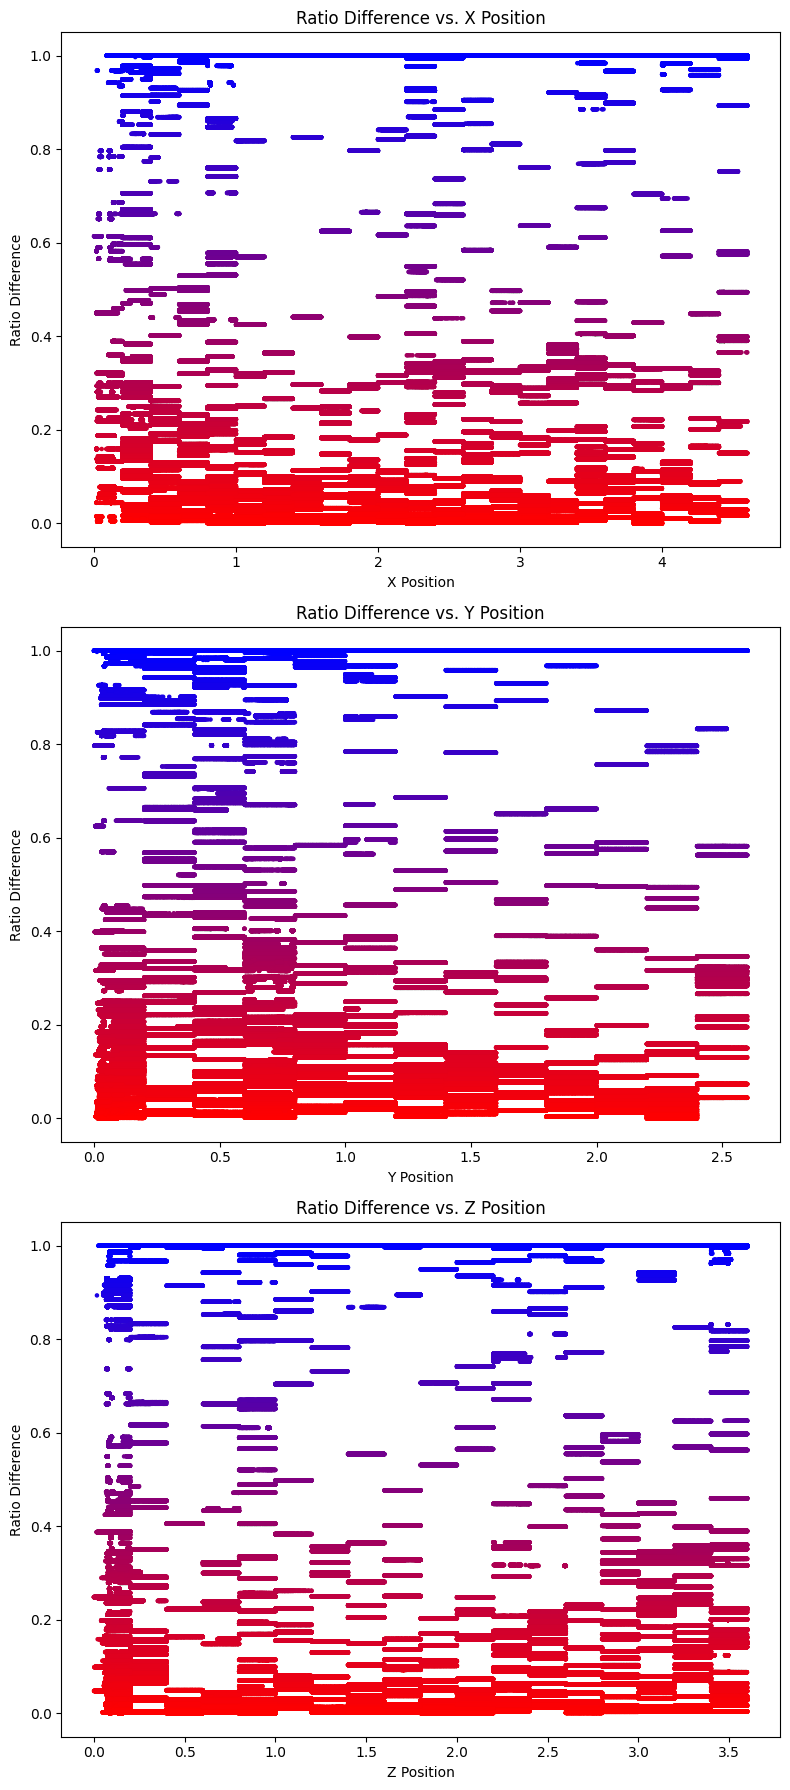

In [33]:
# Extract x, y, z coordinates and ratio_diff from colors
points_np = np.array(points)
colors_np = np.array(colors)

# Calculate ratio_diff as the third component in colors_np (since color is [1-ratio_diff, 0, ratio_diff])
ratio_diff = colors_np[:, 2]

# Create a figure and subplots for x, y, and z relationships
fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# Plot ratio_diff relative to x position
axs[0].scatter(points_np[:, 0], ratio_diff, c=colors_np, s=5)
axs[0].set_xlabel('X Position')
axs[0].set_ylabel('Ratio Difference')
axs[0].set_title('Ratio Difference vs. X Position')

# Plot ratio_diff relative to y position
axs[1].scatter(points_np[:, 1], ratio_diff, c=colors_np, s=5)
axs[1].set_xlabel('Y Position')
axs[1].set_ylabel('Ratio Difference')
axs[1].set_title('Ratio Difference vs. Y Position')

# Plot ratio_diff relative to z position
axs[2].scatter(points_np[:, 2], ratio_diff, c=colors_np, s=5)
axs[2].set_xlabel('Z Position')
axs[2].set_ylabel('Ratio Difference')
axs[2].set_title('Ratio Difference vs. Z Position')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [31]:
# Create a coordinate frame to visualize the world transformation gizmo
gizmo = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])

# Combine all geometries for visualization
geometries = line_sets + [gizmo, bbox_local, bbox_remote, pcd_local, pcd_remote]

# Visualize the voxel wireframes, local, and remote point clouds together
o3d.visualization.draw_geometries(geometries)

In [1]:
# Create a coordinate frame to visualize the world transformation gizmo
gizmo = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])

# Combine all geometries for visualization
geometries = voxel_list + [gizmo, bbox_local, bbox_remote, pcd_local, pcd_remote]

# Visualization with interactive keyboard control
vis = o3d.visualization.VisualizerWithKeyCallback()
vis.create_window()

# # Add geometries to the visualizer
# for geometry in geometries:
#     vis.add_geometry(geometry)

# # Track current clipping bounds
# clip_x = min_bound[0]
# clip_z = min_bound[2]

# # Function to update visibility based on clipping bounds
# def update_visibility():
#     for voxel in voxel_list:
#         center = voxel.get_center()
#         if center[0] < clip_x or center[2] < clip_z:
#             voxel.paint_uniform_color([1, 1, 1])  # Make invisible by setting to white (background color)
#         else:
#             voxel.paint_uniform_color([ratio_remote, 0, ratio_local])  # Original color based on ratio

# # Right arrow key callback to clip cells along the x-axis
# def right_arrow_callback(vis):
#     global clip_x
#     clip_x += grid_size
#     update_visibility()
#     return False

# # Up arrow key callback to clip cells along the z-axis
# def up_arrow_callback(vis):
#     global clip_z
#     clip_z += grid_size
#     update_visibility()
#     return False

# # Register the callbacks
# vis.register_key_callback(ord(""), right_arrow_callback)  # Right arrow
# vis.register_key_callback(ord(""), up_arrow_callback)  # Up arrow

# Run the visualizer
vis.run()
vis.destroy_window()

NameError: name 'o3d' is not defined

In [ ]:
# Proximity map code here...


In [17]:
# Visualize the voxel grid representing overlapping regions
o3d.visualization.draw_geometries([pcd_local, pcd_remote])

In [22]:
# Visualize the result
o3d.visualization.draw_geometries([overlapping_pcd_local, overlapping_pcd_remote, pcd_local, pcd_remote])

In [68]:
# Start timing
total_start_time = time.time()

# Octree Visualizer
curr_max_depth = 8
octree_loc = o3d.geometry.Octree(max_depth = curr_max_depth)
octree_loc.convert_from_point_cloud(pcd_local)
octree_rmt = o3d.geometry.Octree(max_depth = curr_max_depth)
octree_rmt.convert_from_point_cloud(pcd_remote)

measure_execution_time(total_start_time)

Total time taken: 9.15 seconds


In [69]:
def traverse_callback(node, node_info):
    if isinstance(node, o3d.geometry.OctreeLeafNode):
        print("Found a leaf node!")
    elif isinstance(node, o3d.geometry.OctreeInternalNode):
        print("Internal node")
    return True

octree_loc.traverse(traverse_callback)

Internal node


In [12]:
# Create a larger point cloud
points = np.random.rand(1000, 3) * 10  # Higher density and larger range
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Create an octree with adjusted depth and size_expand parameters
octree = o3d.geometry.Octree(max_depth=10)
octree.convert_from_point_cloud(pcd, size_expand=0.1)

# Traverse the octree
def traverse_callback(node, node_info):
    n = 0
    print(n)
    if isinstance(node, o3d.geometry.OctreeColorLeafNode):
        print("Found a leaf node!")
    elif isinstance(node, o3d.geometry.OctreeInternalNode):
        print("Internal node")

    n = n + 1
    return True

octree.traverse(traverse_callback)
#print(len(octree))

0
Internal node


In [3]:
# Create a larger point cloud
points = np.random.rand(1000, 3) * 10  # Higher density and larger range
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Create an octree with adjusted depth and size_expand parameters
octree = o3d.geometry.Octree(max_depth=20)
octree.convert_from_point_cloud(pcd)

o3d.visualization.draw_geometries([pcd, octree])

In [4]:
def f_traverse(node, node_info):
    early_stop = False

    if isinstance(node, o3d.geometry.OctreeInternalNode):
        if isinstance(node, o3d.geometry.OctreeInternalPointNode):
            n = 0
            for child in node.children:
                if child is not None:
                    n += 1
            print(
                "{}{}: Internal node at depth {} has {} children and {} points ({})"
                .format('    ' * node_info.depth,
                        node_info.child_index, node_info.depth, n,
                        len(node.indices), node_info.origin))

            # we only want to process nodes / spatial regions with enough points
            early_stop = len(node.indices) < 250
    elif isinstance(node, o3d.geometry.OctreeLeafNode):
        if isinstance(node, o3d.geometry.OctreePointColorLeafNode):
            print("{}{}: Leaf node at depth {} has {} points with origin {}".
                  format('    ' * node_info.depth, node_info.child_index,
                         node_info.depth, len(node.indices), node_info.origin))
    else:
        raise NotImplementedError('Node type not recognized!')

    # early stopping: if True, traversal of children of the current node will be skipped
    return early_stop

octree.traverse(f_traverse)

0: Internal node at depth 0 has 8 children and 1000 points ([0.02181497 0.00929104 0.00438709])
    0: Internal node at depth 1 has 8 children and 134 points ([0.02181497 0.00929104 0.00438709])
    1: Internal node at depth 1 has 8 children and 132 points ([5.06142288e+00 9.29104450e-03 4.38708557e-03])
    2: Internal node at depth 1 has 8 children and 133 points ([2.18149678e-02 5.04889895e+00 4.38708557e-03])
    3: Internal node at depth 1 has 8 children and 124 points ([5.06142288e+00 5.04889895e+00 4.38708557e-03])
    4: Internal node at depth 1 has 8 children and 123 points ([0.02181497 0.00929104 5.04399499])
    5: Internal node at depth 1 has 8 children and 117 points ([5.06142288 0.00929104 5.04399499])
    6: Internal node at depth 1 has 8 children and 127 points ([0.02181497 5.04889895 5.04399499])
    7: Internal node at depth 1 has 8 children and 110 points ([5.06142288 5.04889895 5.04399499])


In [61]:
# Start timing
total_start_time = time.time()
# def f_traverse(node, node_info):
#     early_stop = False

#     if isinstance(node, o3d.geometry.OctreeInternalNode):
#         if isinstance(node, o3d.geometry.OctreeInternalPointNode):
#             n = 0
#             for child in node.children:
#                 if child is not None:
#                     n += 1
#             print(
#                 "{}{}: Internal node at depth {} has {} children and {} points ({})"
#                 .format('    ' * node_info.depth,
#                         node_info.child_index, node_info.depth, n,
#                         len(node.indices), node_info.origin))

#             # we only want to process nodes / spatial regions with enough points
#             early_stop = len(node.indices) < 250
#     elif isinstance(node, o3d.geometry.OctreeLeafNode):
#         if isinstance(node, o3d.geometry.OctreePointColorLeafNode):
#             print("{}{}: Leaf node at depth {} has {} points with origin {}".
#                   format('    ' * node_info.depth, node_info.child_index,
#                          node_info.depth, len(node.indices), node_info.origin))
#     else:
#         raise NotImplementedError('Node type not recognized!')

#     # early stopping: if True, traversal of children of the current node will be skipped
#     return early_stop

# octree_loc.traverse(f_traverse)

#print(f"octree_loc = {octree_loc}")

# Check collisions between octrees and color overlapping leaves
collision_leaves = []

def traverse_callback(node1, node_info1):
    print(type(node1))
    if isinstance(node1, o3d.geometry.OctreeLeafNode):
        print("In OctreeLeafNode!")
        def compare_callback(node2, node_info2):
            if isinstance(node2, o3d.geometry.OctreeLeafNode):
                # Check if bounding boxes overlap
                print(f"node_info1.origin: {node_info1.origin}, node_info2.origin: {node_info2.origin}")
                bbox1_min = node_info1.origin
                bbox1_max = node_info1.origin + node_info1.size
                bbox2_min = node_info2.origin
                bbox2_max = node_info2.origin + node_info2.size
                if (np.all(bbox1_min < bbox2_max) and np.all(bbox1_max > bbox2_min)):
                    collision_leaves.append(node1)
                    node1.color = [1, 0, 0]
        octree2.traverse(compare_callback)
    elif isinstance(node1, o3d.geometry.OctreeInternalNode):
        print("In InternalNode!")
    #else:
        # raise NotImplementedError('Node type not recognized!')  
    return True

# def check_collision_and_color(octree1, octree2):
#     print(f"octree1: {octree1}")
#     print(f"octree2: {octree2}")
#     def traverse_callback(node1, node_info1):
#         print("In!")
#         if isinstance(node1, o3d.geometry.OctreeLeafNode):
#             def compare_callback(node2, node_info2):
#                 if isinstance(node2, o3d.geometry.OctreeLeafNode):
#                     # Check if bounding boxes overlap
#                     print(f"node_info1.origin: {node_info1.origin}, node_info2.origin: {node_info2.origin}")
#                     bbox1_min = node_info1.origin
#                     bbox1_max = node_info1.origin + node_info1.size
#                     bbox2_min = node_info2.origin
#                     bbox2_max = node_info2.origin + node_info2.size
#                     if (np.all(bbox1_min < bbox2_max) and np.all(bbox1_max > bbox2_min)):
#                         collision_leaves.append(node1)
#                         node1.color = [1, 0, 0]
#             octree2.traverse(compare_callback)
#         #else:
#             # raise NotImplementedError('Node type not recognized!')  
#         return True

#     octree1.traverse(traverse_callback)
    # Color the overlapping leaves in red
    # for leaf in collision_leaves:
    #     leaf.color = [1, 0, 0]

#check_collision_and_color(octree_loc, octree_rmt)
octree_loc.traverse(traverse_callback)

print(f"collision leaves: {len(collision_leaves)}")

o3d.visualization.draw_geometries([gizmo, octree_loc, octree_rmt, bbox_local, bbox_remote])

measure_execution_time(total_start_time)

<class 'open3d.cpu.pybind.geometry.OctreeInternalPointNode'>
In InternalNode!
collision leaves: 0
Total time taken: 3.98 seconds


In [7]:
# Create a coordinate frame to visualize the world transformation gizmo
gizmo = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])

# Visualize the transformed point clouds with the world transformation gizmo and bounding boxes
#o3d.visualization.draw_geometries([gizmo, pcd_local, pcd_remote, bbox_local, bbox_remote])
o3d.visualization.draw_geometries([gizmo, octree_loc, octree_rmt, bbox_local, bbox_remote])

NameError: name 'octree_loc' is not defined